In [2]:
import os
import copy
import time
import random
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models, transforms

from __future__ import print_function
from __future__ import division

from plots import show_df, show_dl
from data import get_data_as_dataframe
from utils import custom_train_test_split

from train import train_one_epoch

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.3.1+cu121
Torchvision Version:  0.18.1+cu121


In [3]:
# ROOT path
ROOT = os.getcwd()

# Training mode
PRETRAINED = True

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# Data Preparation

In [4]:
# Path to datasets
DATA_PATH = os.path.join(ROOT, 'dataset')

df = get_data_as_dataframe(DATA_PATH, dataset_name='SUT-Crack', balance=True)
df.head()

image    label
0  c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...  cracked
1  c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...  cracked
2  c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...  cracked
3  c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...  cracked
4  c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...  cracked

In [5]:
# define the train & test split
TEST_SIZE = 0.2

train_df, valid_df, test_df = custom_train_test_split(df, test_size=TEST_SIZE, stratify='label')

print(f"Train size: {train_df.shape}")
print(f"Validation size: {valid_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (3017, 2)
Validation size: (566, 2)
Test size: (189, 2)


In [6]:
print(f"Train data balance:\n {train_df.label.value_counts()}\n")
print(f"Validation data balance:\n {valid_df.label.value_counts()}\n")
print(f"Test data balance:\n {test_df.label.value_counts()}\n")

Train data balance:
 non-cracked    1509
cracked        1508
Name: label, dtype: int64

Validation data balance:
 cracked        283
non-cracked    283
Name: label, dtype: int64

Test data balance:
 cracked        95
non-cracked    94
Name: label, dtype: int64



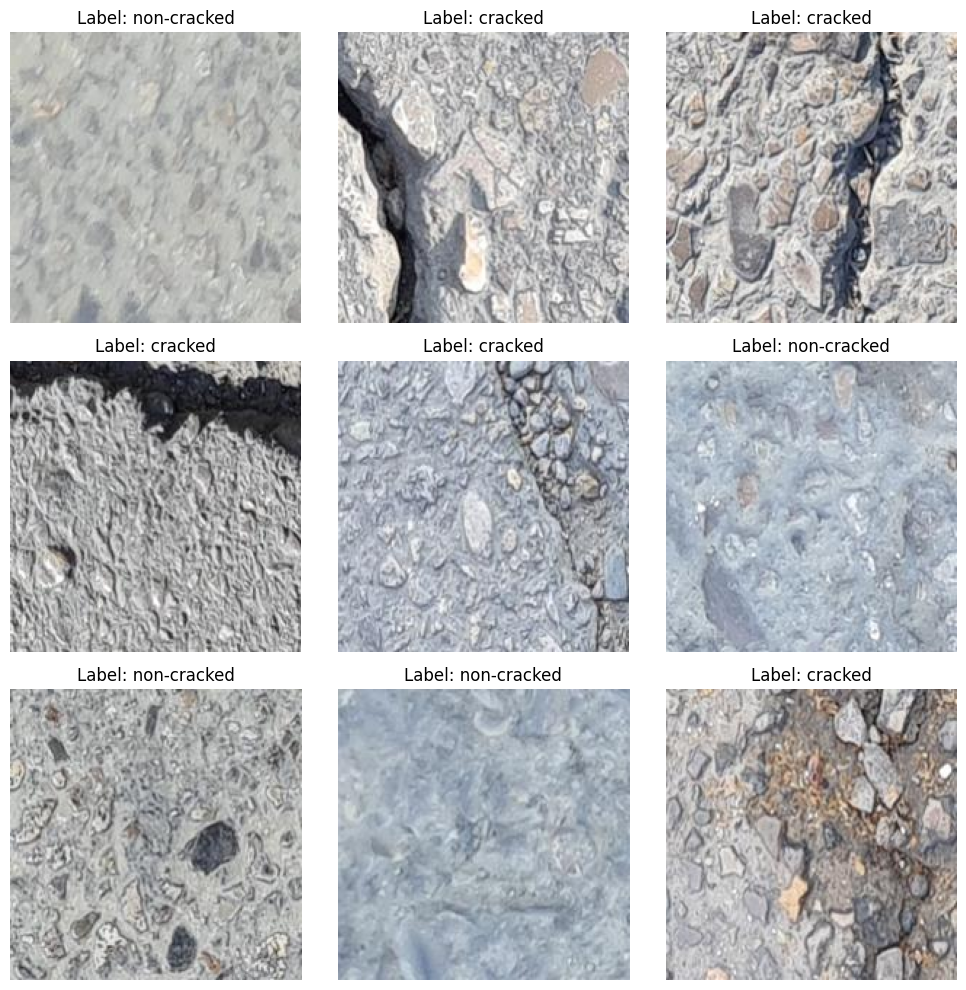

In [7]:
show_df(n_samples=9, df=df)

# Initialize Dataset and Dataloader for Training

In [13]:
class CrackDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df_data = df.values
        self.transform = transform

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        img_path, label = self.df_data[idx]
        image = Image.open(img_path).convert("RGB")
        label = 1 if label=='cracked' else 0

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [10]:
def calculate_mean_std(df):
  """
  This function calculates the mean and standard deviation of pixel values across all images in a DataFrame.

  Args:
      df (pandas.DataFrame): A DataFrame containing columns for image paths ('path') and labels ('label').

  Returns:
      tuple: A tuple containing two NumPy arrays: mean and standard deviation of pixel values.
  """

  images = []
  for path in df['image']:
      image = Image.open(path).convert('RGB')
      images.append(np.array(image) / 255.0)
  images = np.array(images)
  
  # Flatten the image data for calculating mean and std
  data = images.reshape(-1, images.shape[-1])  # -1 refers to inferring the number of rows
  mean = np.mean(data, axis=0)
  std = np.std(data, axis=0)
  return mean, std

mean, std = calculate_mean_std(train_df.copy())
print(f"Mean: {mean}, Std: {std}")

Mean: [0.64487537 0.64924528 0.65313811], Std: [0.15578018 0.15209795 0.14695091]


In [14]:
# define the input image dimensions
IMG_SIZE = 224

# define the batch size
BATCH_SIZE = 32

if PRETRAINED:
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
else:
    MEAN, STD = data_normalization()

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # ImageNet normalization
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # ImageNet normalization
    ])
}

train_dataset = CrackDataset(train_df, transform=data_transforms['train'])

dataloaders = {
    'train': DataLoader(CrackDataset(train_df, transform=data_transforms['train']), 
                        batch_size=BATCH_SIZE, shuffle=True, 
                        pin_memory=PIN_MEMORY),
    'valid': DataLoader(CrackDataset(valid_df, transform=data_transforms['valid']), 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        pin_memory=PIN_MEMORY),
    'test': DataLoader(CrackDataset(test_df, transform=data_transforms['valid']), 
                       batch_size=1, shuffle=False,
                       pin_memory=PIN_MEMORY)
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: 32
tensor(-0.7899) tensor(1.3314)
tensor(-0.5241) tensor(1.3314)
tensor(-0.7567) tensor(1.3314)
tensor(-0.1504) tensor(1.3031)
tensor(-0.3414) tensor(1.1398)
tensor(-0.7151) tensor(1.3314)
tensor(-0.0756) tensor(1.3314)
tensor(-0.3082) tensor(1.3314)
tensor(-0.1254) tensor(1.3155)
tensor(-0.3497) tensor(1.3314)
tensor(-0.1504) tensor(1.3155)
tensor(-0.7733) tensor(1.3314)
tensor(-0.2999) tensor(1.3314)
tensor(-0.4992) tensor(1.2676)
tensor(-0.3530) tensor(1.3075)
tensor(-0.7982) tensor(1.3314)
tensor(-0.6487) tensor(1.3234)
tensor(-0.7400) tensor(1.3314)
tensor(-0.0424) tensor(1.2968)
tensor(-0.7484) tensor(1.3314)
tensor(-0.4992) tensor(1.3314)
tensor(-0.7982) tensor(1.3314)
tensor(-0.6570) tensor(1.3075)
tensor(-0.4909) tensor(1.3314)
tensor(-0.6653) tensor(1.3234)
tensor(-0.4327) tensor(1.3314)
tensor(-0.3414) tensor(1.2615)
tensor(-0.3663) tensor(1.2615)
tensor(-0.7816) tensor(1.3314)
tensor(-0.7234) tensor(1.331

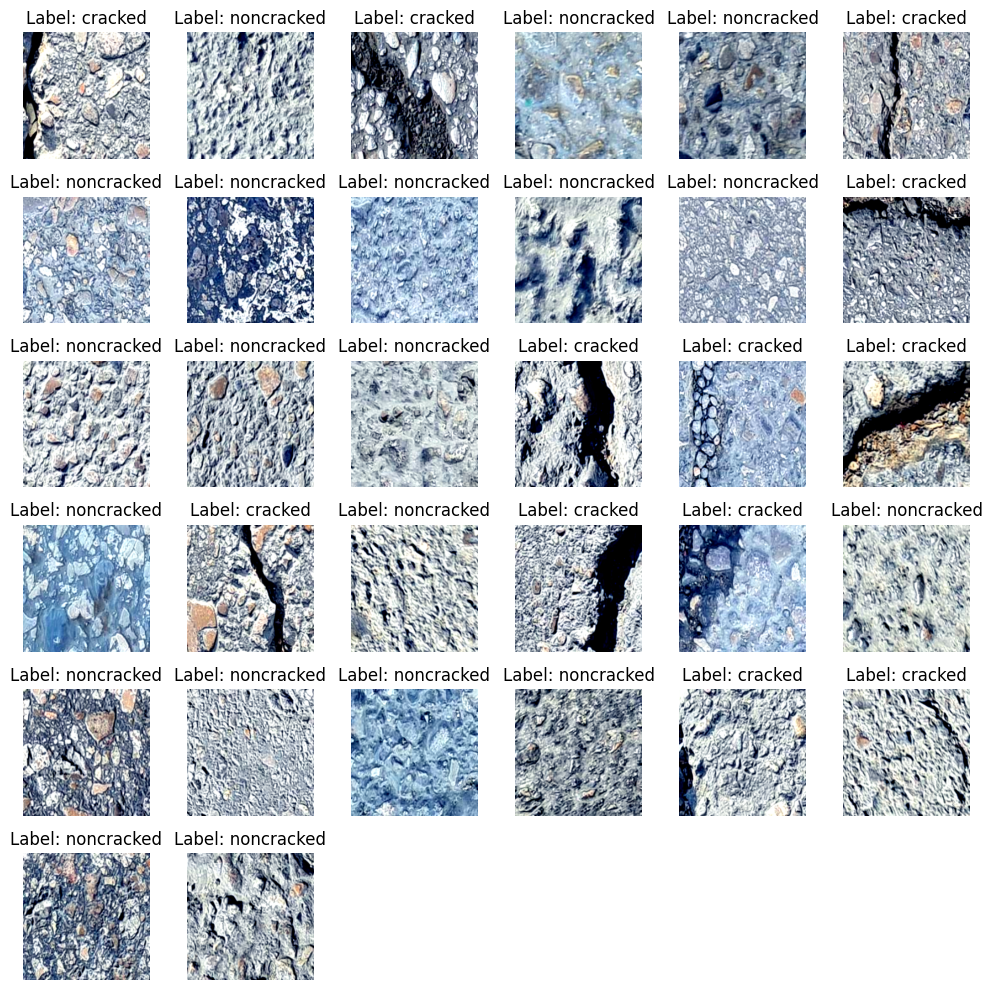

In [29]:
cols = 6
n_samples = None
dl = dataloaders['train']
figsize = (10, 10)
images, labels = next(iter(dl))

labels

if n_samples:
    if n_samples > len(images):
        n_samples = len(images)

    rows, reminder = divmod(n_samples, cols)
    if reminder > 0:  # Adding an extra row
        rows += 1
else:
    n_samples = len(images)
    rows, reminder = divmod(n_samples, cols)
    if reminder > 0:  # Adding an extra row
        rows += 1

fig, axes = plt.subplots(rows, cols, figsize=figsize)

axes_flat = axes.flatten()

print(f"Images batch shape: {images.size()}")
print(f"Labels batch shape: {len(labels)}")

for i in range(n_samples):
    axes_flat[i].imshow(images[i].permute(1, 2, 0))
    axes_flat[i].axis('off')
    axes_flat[i].set_title(f"Label: {'cracked' if labels[i]==1 else 'noncracked'}")

for j in range(n_samples, rows*cols):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()

95


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: 32


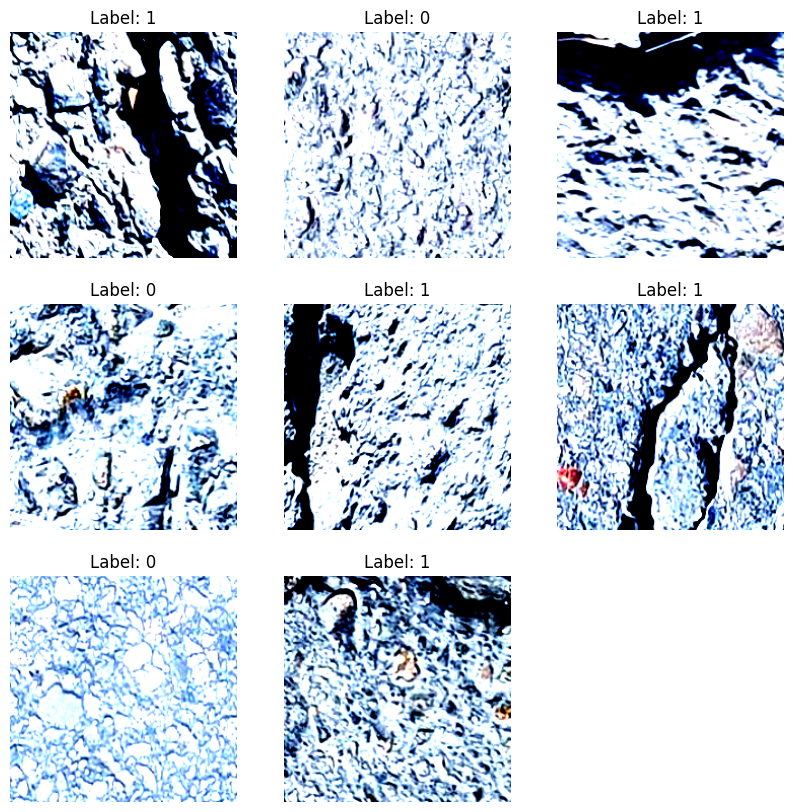

In [15]:
fig = plt.figure(figsize=(10, 10))

print(len(dataloaders['train']))

train_imgs, train_labels = next(iter(dataloaders['train']))
print(f"Images batch shape: {train_imgs.size()}")
print(f"Labels batch shape: {len(train_labels)}")

samples_from_batch = len(train_imgs)//4
for i in range(samples_from_batch):
    fig.add_subplot(samples_from_batch//3+1, 3, (i+1))
    plt.imshow(train_imgs[i].permute(1, 2, 0))
    # plt.title(f"Label: {'cracked' if train_labels[i]==1 else 'noncracked'}")
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')

plt.show()

# ViT (Vision Transformer) Architecture

In [ ]:
def vit(model, pretrained=False):
    

In [11]:
model = models.vit_b_16(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False
    
num_classes = len(df.label.unique())
        
num_features_in = model.heads.head.in_features
model.heads.head = torch.nn.Linear(num_features_in, num_classes)

In [25]:
# model

In [26]:
# params_to_update = model.parameters()
# print("Params to learn:\n")
# if feature_extract:
#     params_to_update = []
#     for name,param in model.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print(name)
# else:
#     for name,param in model.named_parameters():
#         if param.requires_grad == True:
#             print(name)

# Fine-tune ViT

In [12]:
# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 1.5e-3
MOMENTUM = 0.9

# Send the model to GPU
model = model.to(DEVICE)

# Setup the loss function
criterion = torch.nn.CrossEntropyLoss()

# Model parameters where requires grad is True
params_to_tune = [param for param in model.parameters() if param.requires_grad]

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM)

In [28]:
# model = models.vit_b_16(weights='DEFAULT')

# for param in model.parameters():
#     param.requires_grad = False
    
# num_classes = len(df.labels.unique())
        
# num_features_in = model.heads.head.in_features
# model.heads.head = torch.nn.Linear(num_features_in, num_classes)

# # initialize learning rate, number of epochs to train for, and the batch size
# INIT_LR = 2.5e-3
# MOMENTUM = 0.9

# # Send the model to GPU
# model = model.to(DEVICE)

# # Setup the loss function
# criterion = torch.nn.CrossEntropyLoss()

# # Model parameters where requires grad is True
# params_to_tune = [param for param in model.parameters() if param.requires_grad]

# # Observe that all parameters are being optimized
# optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM)

# NUM_EPOCHS = 10

# train_inputs, train_labels = next(iter(dataloaders['train']))
# val_inputs, val_labels = next(iter(dataloaders['valid']))

# # Train the model for the specified number of epochs
# for epoch in range(NUM_EPOCHS):
#     print(f'Epoch {epoch}')
#     # Set the model to train mode
#     model.train()

#     # Initialize the running loss and accuracy
#     batch_train_loss = 0.0
#     batch_train_corrects = 0

#     # # Iterate over the batches of the train loader
#     # for inputs, labels in train_loader:
#     # Move the inputs and labels to the device
#     train_inputs = train_inputs.to(DEVICE)
#     train_labels = train_labels.to(DEVICE)

#     # Forward pass
#     outputs = model(train_inputs)
#     _, preds = torch.max(outputs, 1)
#     loss = criterion(outputs, train_labels)
    
#     # Zero the optimizer gradients
#     optimizer.zero_grad()
    
#     # Backward pass and optimizer step
#     loss.backward()
#     optimizer.step()

#     # Update the running loss and accuracy
#     batch_train_loss += loss.item() * train_inputs.size(0)
#     batch_train_corrects += torch.sum(preds == train_labels.data)

# #     # Calculate the train loss and accuracy
# #     train_dataset_len = dataloaders['train'].dataset.__len__()
# #     train_epoch_loss = batch_loss / train_dataset_len
# #     train_epoch_acc = batch_corrects.double() / train_dataset_len

#     print(f'Train Loss: {batch_train_loss}, Train Accuracy: {batch_train_corrects/32}')
    
#     # Set the model to evaluation mode
#     model.eval()

#     # Initialize the running loss and accuracy
#     batch_val_loss = 0.0
#     batch_val_corrects = 0

#     # Iterate over the batches of the validation loader
#     with torch.no_grad():
# #         for inputs, labels in val_loader:
# #             # Move the inputs and labels to the device
#         val_inputs = val_inputs.to(DEVICE)
#         val_labels = val_labels.to(DEVICE)

#         # Forward pass
#         outputs = model(val_inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, val_labels)

#         # Update the running loss and accuracy
#         batch_val_loss += loss.item() * val_inputs.size(0)
#         batch_val_corrects += torch.sum(preds == val_labels.data)
        
#     print(f'Validation Loss: {batch_val_loss}, Validation Accuracy: {batch_val_corrects/32}\n')



#     # Calculate the validation loss and accuracy
# #     val_loss = running_loss / len(val_dataset)
# #     val_acc = running_corrects.double() / len(val_dataset)

In [14]:
NUM_EPOCHS = 100

train_losses = []
val_losses = []

# Train the model for the specified number of epochs
for epoch in range(NUM_EPOCHS):
    train_loss, val_loss, train_acc, val_acc = train_one_epoch(model, dataloaders, criterion, optimizer, device=DEVICE)
    
    # Print the epoch results
    print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
          .format(epoch+1, NUM_EPOCHS, train_loss, train_acc, val_loss, val_acc))
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

c:\Users\r.fatali\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/100], train loss: 0.0788, train acc: 0.9718, val loss: 0.0648, val acc: 0.9755
Epoch [2/100], train loss: 0.0588, train acc: 0.9792, val loss: 0.0579, val acc: 0.9778
Epoch [3/100], train loss: 0.0535, train acc: 0.9802, val loss: 0.0553, val acc: 0.9780
Epoch [4/100], train loss: 0.0505, train acc: 0.9816, val loss: 0.0535, val acc: 0.9800
Epoch [5/100], train loss: 0.0484, train acc: 0.9821, val loss: 0.0550, val acc: 0.9786
Epoch [6/100], train loss: 0.0465, train acc: 0.9830, val loss: 0.0505, val acc: 0.9804
Epoch [7/100], train loss: 0.0453, train acc: 0.9831, val loss: 0.0509, val acc: 0.9807
Epoch [8/100], train loss: 0.0441, train acc: 0.9836, val loss: 0.0499, val acc: 0.9816
Epoch [9/100], train loss: 0.0432, train acc: 0.9841, val loss: 0.0487, val acc: 0.9815
Epoch [10/100], train loss: 0.0424, train acc: 0.9842, val loss: 0.0488, val acc: 0.9818
Epoch [11/100], train loss: 0.0418, train acc: 0.9845, val loss: 0.0487, val acc: 0.9809
Epoch [12/100], train loss: 0.

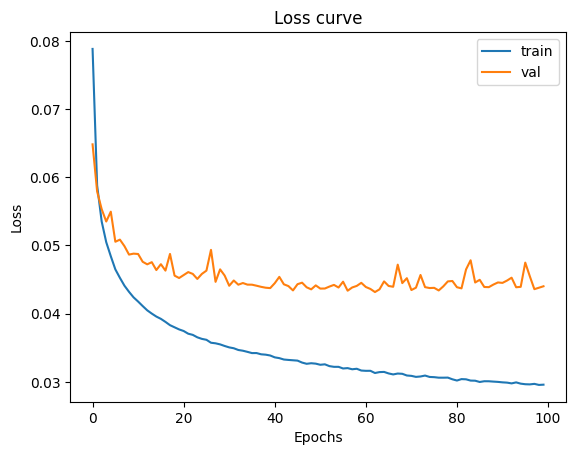

In [15]:
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

In [23]:
model.eval()

batch_loss = 0.0
batch_corrects = 0
# Iterate over the batches of the validation loader
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        # Move the inputs and labels to the device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Update the running loss and accuracy
        batch_loss += loss.item() * inputs.size(0)
        batch_corrects += torch.sum(preds == labels.data)

test_dataset_len = dataloaders['test'].dataset.__len__()
test_loss = batch_loss / test_dataset_len
test_acc = batch_corrects.double() / test_dataset_len

print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 0.04016652987898976, test acc: 0.9844897959183674


In [23]:
# def train_one_epoch(model, dataloaders, criterion, optimizer):
#     for phase in ['train', 'valid']:
#         if phase == 'train':
#             model.train()  # Set model to training mode
#         else:
#             model.eval()   # Set model to evaluate mode

#         running_loss = 0.0
#         running_corrects = 0

#         # Iterate over data.
#         for inputs, labels in dataloaders[phase]:
#             inputs = inputs.to(DEVICE)
#             labels = labels.to(DEVICE)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             # track history if only in train
#             with torch.set_grad_enabled(phase=='train'):
#                 # Get model outputs and calculate loss
#                 # Special case for inception because in training it has an auxiliary output. In train
#                 #   mode we calculate the loss by summing the final output and the auxiliary output
#                 #   but in testing we only consider the final output.
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 _, preds = torch.max(outputs, 1)

#                 # backward + optimize only if in training phase
#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             # statistics
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(dataloaders[phase].dataset)
#         epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
#         return epoch_loss, epoch_acc

# def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
#     since = time.time()

#     val_acc_history = []
    
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

        

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, val_acc_history

In [25]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 0/99
----------


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
